In [145]:
import pandas as pd
import os
import numpy as np
import statsmodels.stats.multitest as multi
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [146]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Get association files

In [147]:
directory="/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"
files=[x for x in os.listdir(directory) if "add" in x]

In [148]:
files.remove("melanoma.assoc.logistic.add")
files.remove("rcc.assoc.logistic.add")
files.remove("nsclc.assoc.logistic.add")

In [149]:
files

['hugo.assoc.logistic.add',
 'miao.assoc.logistic.add',
 'rizvi.assoc.logistic.add',
 'vanallen.assoc.logistic.add',
 'snyder.assoc.logistic.add',
 'riaz.assoc.logistic.add']

In [150]:
files=[x.split(".")[0] for x in files]

In [151]:
compiled_freq=pd.DataFrame()

for x in files:
    f=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"+x+".freq.afreq",delimiter="\t")
    df=f[f["ALT_FREQS"]>.01]
    df["study"]=x
    compiled_freq=compiled_freq.append(df)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### keep only ids that are MAF > 1% in at least 6 studies

In [152]:
compiled_counts=compiled_freq["ID"].value_counts().reset_index()

In [153]:
len(compiled_counts[compiled_counts["ID"]>5])

69

In [154]:
icb_snps=pd.DataFrame({"snps":compiled_counts[compiled_counts["ID"]>5]["index"].tolist()})

In [155]:
icb_snps.to_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/icb_snps.txt",header=None,index=None,sep="\t")

In [156]:
icb_snps=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/icb_snps.txt",header=None,sep="\t")[0].tolist()

In [158]:
compiled_or=pd.DataFrame()

for x in files:
    f=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"+x+".assoc.logistic.add",delimiter="\t")
    f["study"]=x
    compiled_or=compiled_or.append(f)

In [163]:
compiled_or["snp_noallele"]=compiled_or["ID"].str.rsplit(":",2).str[0]

In [165]:
compiled_or_filt[compiled_or_filt["P"]<.05]

,#CHROM,POS,ID,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,ERRCODE,study,snp_noallele
40,1,89473624,1:89473624:G:A,G,A,A,N,ADD,64,2.481440,0.429576,2.11566,0.034374,.,snyder,1:89473624
47,1,150678910,1:150678910:T:C,T,C,C,N,ADD,64,4.030790,0.637671,2.18602,0.028814,.,snyder,1:150678910
300,10,71880791,10:71880791:C:G,C,G,G,N,ADD,67,3.133880,0.541751,2.10848,0.034990,.,riaz,10:71880791
320,11,65561369,11:65561369:G:A,G,A,A,N,ADD,67,0.096454,0.717185,-3.26093,0.001110,.,riaz,11:65561369
42,1,89478868,1:89478868:G:A,G,A,A,N,ADD,107,0.201590,0.632559,-2.53181,0.011348,.,vanallen,1:89478868
43,1,89735314,1:89735314:G:A,G,A,A,N,ADD,107,0.204758,0.649514,-2.44172,0.014618,.,vanallen,1:89735314
70,2,219259844,2:219259844:A:G,A,G,G,N,ADD,107,0.284133,0.424304,-2.96559,0.003021,.,vanallen,2:219259844
425,19,54754385,19:54754385:T:G,T,G,G,N,ADD,107,3.607640,0.608809,2.10748,0.035076,.,vanallen,19:54754385
455,19,55025471,19:55025471:C:A,C,A,A,N,ADD,107,2.709760,0.451705,2.20688,0.027322,.,vanallen,19:55025471
438,19,54848986,19:54848986:C:T,C,T,T,N,ADD,34,0.082968,1.027900,-2.42174,0.015446,.,rizvi,19:54848986


## Get METAL results

In [167]:
#get metal analysis results
df=pd.read_csv("/cellar/users/mpagadal/Programs/generic-metal/METAANALYSIS1.TBL",delimiter="\t")

In [168]:
df=df.sort_values(by="P-value")

In [169]:
def fdr(df,p):
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    return(df)

In [170]:
df=df.reset_index()

In [171]:
df=df[df["MarkerName"].isin(compiled_counts[compiled_counts["ID"]>5]["index"].tolist())]

In [172]:
def ppoints(n, a):
    """ numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number"""
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

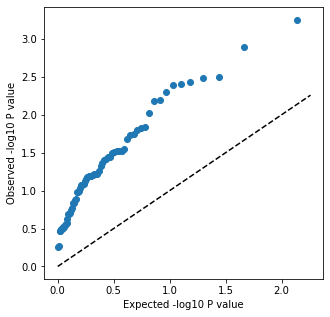

In [173]:
compiled=pd.DataFrame()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
p_values=df.sort_values(by="P-value")["P-value"].tolist()
plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values))
ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel('Observed -log10 P value')
plt.savefig("../plots/qq.pdf")

## Filter for variants with FDR < 10%

In [174]:
df=fdr(df,"P-value")

In [175]:
df_sig=df[df["P-value"]<.05]

In [176]:
df_sig=df[df["fdr"]<0.1]

In [177]:
df_sig["snp_noallele"]=df_sig["MarkerName"].str.rsplit(":",2).str[0]

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [178]:
snps=pd.read_csv("../../snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [179]:
df_sig["snp_noallele"]=df_sig["MarkerName"].str.rsplit(":",2).str[0]

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [180]:
df_sig.head()

,index,MarkerName,Allele1,Allele2,Weight,Zscore,P-value,Direction,fdr,-log10(fdr),snp_noallele
0,228,2:219259844:A:G,a,g,378.0,-3.447,0.000566,------,0.039047,1.408411,2:219259844
1,118,19:54848986:C:T,t,c,378.0,3.219,0.001289,++++++,0.040119,1.396655,19:54848986
2,184,1:89473624:G:A,a,g,378.0,2.952,0.003158,++++++,0.040119,1.396655,1:89473624
3,345,1:89735314:G:A,a,g,378.0,2.942,0.003257,++++++,0.040119,1.396655,1:89735314
4,104,19:54754385:T:G,t,g,378.0,-2.902,0.003707,------,0.040119,1.396655,19:54754385


In [181]:
snps["snp_noallele"]=snps["snps"].str.rsplit(":",2).str[0]

In [182]:
pd.merge(df_sig,snps[["snp_noallele","REF","ALT","tpm beta","file"]],on="snp_noallele")

,index,MarkerName,Allele1,Allele2,Weight,Zscore,P-value,Direction,fdr,-log10(fdr),snp_noallele,REF,ALT,tpm beta,file
0,228,2:219259844:A:G,a,g,378.0,-3.447,0.000566,------,0.039047,1.408411,2:219259844,A,G,0.104571,SLC11A1
1,118,19:54848986:C:T,t,c,378.0,3.219,0.001289,++++++,0.040119,1.396655,19:54848986,C,T,-0.189505,LAIR1
2,184,1:89473624:G:A,a,g,378.0,2.952,0.003158,++++++,0.040119,1.396655,1:89473624,G,A,-0.208965,CCBL2
3,345,1:89735314:G:A,a,g,378.0,2.942,0.003257,++++++,0.040119,1.396655,1:89735314,G,A,0.137199,CCBL2
4,104,19:54754385:T:G,t,g,378.0,-2.902,0.003707,------,0.040119,1.396655,19:54754385,T,G,0.139727,LILRB2
5,69,11:65561369:G:A,a,g,378.0,2.883,0.003942,++++++,0.040119,1.396655,11:65561369,G,A,0.113429,CTSW
6,122,1:150678910:T:C,t,c,378.0,-2.873,0.004070,------,0.040119,1.396655,1:150678910,T,C,0.126770,CTSS
7,261,12:69744014:C:A,a,c,378.0,2.811,0.004939,++++++,0.042599,1.370602,12:69744014,C,A,0.176987,LYZ
8,231,1:89478868:G:A,a,g,378.0,2.726,0.006407,++++++,0.046085,1.336439,1:89478868,G,A,0.129896,CCBL2
9,271,15:42439444:C:T,t,c,378.0,2.712,0.006679,++++++,0.046085,1.336439,15:42439444,C,T,0.240991,B2M


In [43]:
compiled_icb=pd.DataFrame()

for x in files:
    df=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/associations/metal/"+x+".assoc.logistic.add",delimiter="\t")
    df["study"]=x
    compiled_icb=compiled_icb.append(df)

In [44]:
compiled_icb_plot=compiled_icb[compiled_icb["ID"].isin(df_sig["MarkerName"].tolist())]

In [48]:
compiled_icb_plot[compiled_icb_plot["ID"].str.contains("19:54754385")]

,#CHROM,POS,ID,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,ERRCODE,study
425,19,54754385,19:54754385:T:G,T,G,G,N,ADD,64,1.294300,0.457807,0.563498,0.573096,.,snyder
425,19,54754385,19:54754385:T:G,T,G,G,N,ADD,67,0.558366,0.509179,-1.144470,0.252428,.,riaz
425,19,54754385,19:54754385:T:G,T,G,G,N,ADD,107,3.607640,0.608809,2.107480,0.035076,.,vanallen
425,19,54754385,19:54754385:T:G,T,G,G,N,ADD,34,0.355421,1.471890,-0.702804,0.482178,.,rizvi
425,19,54754385,19:54754385:T:G,T,G,G,N,ADD,38,0.359133,0.955156,-1.072140,0.283656,.,hugo
425,19,54754385,19:54754385:T:G,T,G,G,N,ADD,9,0.555797,1.768340,-0.332149,0.739776,.,miao


In [41]:
compiled_OR=compiled_icb_plot.pivot(index="ID",columns="study",values=["OR","P","A1"])

In [31]:
compiled_OR.to_csv("../data/TIME.icb.OR.tsv",sep="\t")

In [32]:
compiled_icb_plot=compiled_icb_plot.pivot(index="ID",columns="study",values="OR")

In [33]:
compiled_icb_plot

study,hugo,miao,riaz,rizvi,snyder,vanallen
ID,,,,,,
11:65561369:G:A,0.468466,2.024790e+00,0.096454,1.459060,1.840900,1.685320
12:69744014:C:A,5.831680,3.627290e+01,7.862500,5.860070,3.928210,1.330800
19:54754385:T:G,0.359133,5.557970e-01,0.558366,0.355421,1.294300,3.607640
19:54848589:C:G,1.604090,7.127190e-08,1.276480,5.483400,0.873008,1.772120
19:54848986:C:T,2.631690,3.051300e+00,1.530640,0.082968,1.956450,1.267870
19:55173814:G:C,0.262434,2.663900e+00,0.202450,5.691010,0.486624,4.003130
1:1421752:G:A,5.054600,1.513820e+01,0.139351,1.438630,0.435345,0.425578
1:150678910:T:C,0.591726,1.461490e+01,1.449430,2.270740,4.030790,1.698280
1:89473624:G:A,0.549515,6.919200e-01,0.519751,0.685205,2.481440,1.864260


In [28]:
col=[]

for x in compiled_icb_plot.columns:
    if x in ["hugo","riaz","snyder","vanallen"]:
        col.append("green")
    if x in ["rizvi"]:
        col.append("red")
    else:
        col.append("blue")
        

In [29]:
compiled_icb_plot=compiled_icb_plot.fillna(0)

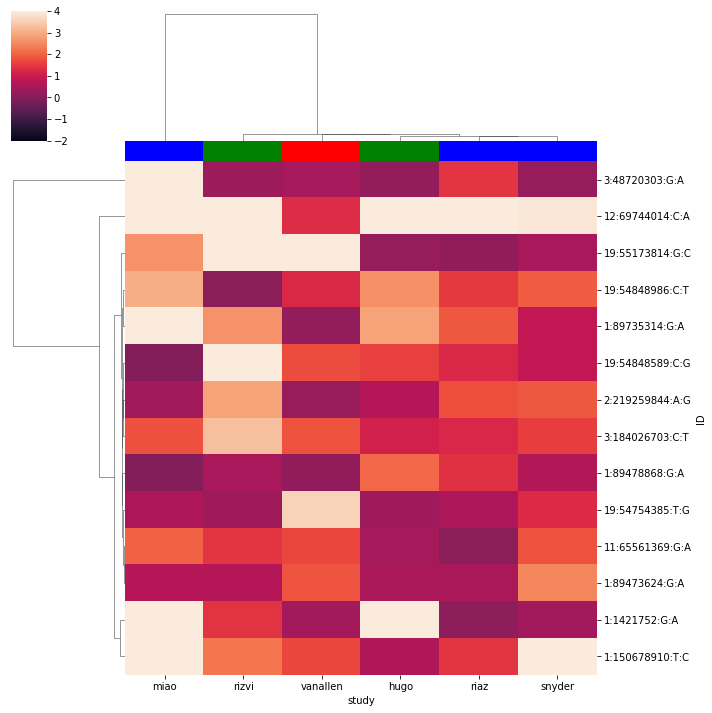

In [30]:
sns.clustermap(compiled_icb_plot,vmin=-2,vmax=4,col_colors=col)
plt.savefig("../plots/icb.clustermap.pdf")

## Annotate samples

In [31]:
snps=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [32]:
snps["assoc"]=snps["snps"]+"_"+snps["file"]

In [33]:
mp_assoc=dict(zip(snps["snps"],snps["assoc"]))

In [34]:
compiled_icb_plot["pheno"]=compiled_icb_plot.index.map(mp_assoc)

In [35]:
for x in set([x.split("_")[1] for x in compiled_icb_plot["pheno"]]):
    print(x)

SLC25A40
CTSW
LILRB2
LAIR1
SLC11A1
LILRB4
LYZ
PSMD2
CTSS
TREX1
CCBL2


In [58]:
snps[snps["snps"].isin(icb_snps["snps"].tolist())]

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,assoc
54,19:54848986:C:T,LAIR1,immunomodulators,0.21680,chr19:g.54848986C>T,rs36068997,-0.189505,0.020223,9.480300e-21,C,T,0.004545,0.020622,8.255600e-01,0.004824,0.020248,8.117140e-01,9.480300e-21,16248.0,19:54848986:C:T_LAIR1
61,19:54848589:C:G,LAIR1,immunomodulators,0.25260,chr19:g.54848589C>G,rs113109589,0.147105,0.019317,2.971350e-14,C,G,0.025998,0.019675,1.864260e-01,0.027989,0.019343,1.479620e-01,2.971350e-14,16645.0,19:54848589:C:G_LAIR1
62,19:54849399:T:C,LAIR1,immunomodulators,0.07198,chr19:g.54849399T>C,rs10419832,-0.241417,0.031978,4.921460e-14,T,C,-0.054045,0.032544,9.682900e-02,-0.045744,0.032020,1.531620e-01,4.921460e-14,15835.0,19:54849399:T:C_LAIR1
71,19:54800371:T:C,LILRB2,antigen present,0.27770,chr19:g.54800371T>C,rs410852,-0.246490,0.018271,5.627670e-41,T,C,-0.053450,0.018888,4.670310e-03,-0.057569,0.018536,1.904980e-03,5.627670e-41,-22697.0,19:54800371:T:C_LILRB2
77,19:54754385:T:G,LILRB2,antigen present,0.33260,chr19:g.54754385T>G,rs2361796,0.139727,0.017345,9.210950e-16,T,G,-0.018438,0.017799,3.002820e-01,-0.022086,0.017484,2.065590e-01,9.210950e-16,23289.0,19:54754385:T:G_LILRB2
78,19:54743056:C:T,LILRB2,antigen present,0.13670,chr19:g.54743056C>T,rs10401694,0.189658,0.023879,2.286910e-15,C,T,-0.019792,0.024470,4.186530e-01,-0.016336,0.024096,4.978270e-01,2.286910e-15,34618.0,19:54743056:C:T_LILRB2
84,19:54687334:C:G,LILRB2,antigen present,0.47380,chr19:g.54687334C>G,rs254283,0.090547,0.016742,6.571640e-08,C,G,0.039079,0.017121,2.248600e-02,0.035129,0.016826,3.685530e-02,6.571640e-08,90340.0,19:54687334:C:G_LILRB2
88,1:150678910:T:C,CTSS,immunomodulators,0.39710,chr1:g.150678910T>C,rs1336899,0.126770,0.017082,1.296960e-13,T,C,0.132358,0.017305,2.309320e-14,0.138944,0.017029,3.957010e-16,3.957010e-16,23761.0,1:150678910:T:C_CTSS
94,1:79100762:A:T,IFI44L,immunomodulators,0.33500,chr1:g.79100762A>T,rs273255,-0.110721,0.017772,4.929690e-10,A,T,-0.043332,0.018101,1.669990e-02,-0.040502,0.017758,2.258630e-02,4.929690e-10,-14675.0,1:79100762:A:T_IFI44L
97,11:60103112:T:C,MS4A4A,cell type,0.32180,chr11:g.60103112T>C,rs12798157,0.104509,0.017756,4.139830e-09,T,C,0.112073,0.018040,5.523400e-10,0.111128,0.017708,3.687790e-10,3.687790e-10,-55099.0,11:60103112:T:C_MS4A4A


In [48]:
icb_snps

,snps
0,19:55025471:C:A
1,11:65392357:G:A
2,19:55174498:T:C
3,5:96233463:C:G
4,19:54752624:T:C
...,...
64,19:52130488:G:A
65,15:42439444:C:T
66,1:89478868:G:A
67,1:79100762:A:T
